In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

from pathlib import Path
import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
sys.path.append(os.path.join(ipynb_dir, '..'))  # Needed for import below

from sc2sensor.dataset import SensorCIFAR10
from sc2sensor.dataset import LABELS_DICT, DEFAULT_10
from sc2sensor.utils.image_utils import imshow


root = '/local/scratch/a/shared/starcraft_shared'
subdir = 'starcraft-sensor-dataset'
model_root_dir = Path('models')

IMAGE_SIZE = [3, 32,32]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class DecoloredSensorDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def decolor_image(self, image):
        return image.mean(dim=0)
        
    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # getting target (uncorrupted image)
        grayscaled_image = self.decolor_image(image).unsqueeze(0).float()  # making uncolored version of image
        return grayscaled_image, image

In [3]:
faulty_sensor_radius = 5

transform = transforms.ToTensor()

batch_size = 256

cifar_trainset = SensorCIFAR10(root=root, subdir=subdir, train=True, transform=transform)
trainset = DecoloredSensorDataset(cifar_trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

cifar_testset = SensorCIFAR10(root=root, subdir=subdir, train=False, transform=transform)
testset = DecoloredSensorDataset(cifar_testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16)

dataloaders = {'train': trainloader, 'val':testloader}

Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorCIFAR10_train.npz
Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorCIFAR10_test.npz


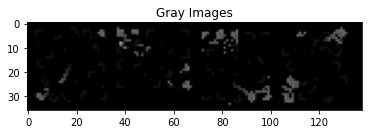

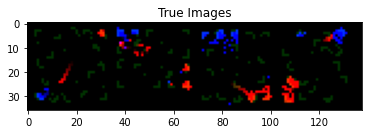

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(trainloader)
gray_images, true_images = dataiter.next()

# show grayed images
imshow(torchvision.utils.make_grid(gray_images[:min(4, batch_size)]), title='Gray Images')
# show true image
imshow(torchvision.utils.make_grid(true_images[:min(4, batch_size)]), title='True Images')
plt.show()

In [16]:
def plot_frames(frames, show=True, axes=None):
    """frames must be len=3 (input, true, pred)"""
    if axes is None:
        fig, axes = plt.subplots(1, 3)
    else:
        assert axes.ndim == 1
        
    imshow(frames[1], ax=axes[1], title='true window')
    imshow(frames[2], ax=axes[2], title='pred window')
    imshow(frames[0], ax=axes[0], title='input window')

    for ax in axes:
        ax.axis('off')
    
    if show:
        plt.tight_layout()
        plt.show()
    return axes

def test_and_plot_model(model, dataloader, n_test_samples=10, axes=None, rng=None):
    if rng is None:
        rng = np.random.RandomState(42)
    for (inputs, targets) in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            # get model predictions and calculate loss
            predictions = model(inputs)
        break
        
    for sample_idx in range(n_test_samples):
        idx = rng.choice(predictions.shape[0])
        if axes is None:
            plot_frames([inputs[idx].cpu(), targets[idx].cpu(), predictions[idx].cpu()])
        else:
            plot_frames([inputs[idx].cpu(), targets[idx].cpu(), predictions[idx].cpu()],
                        axes=axes[sample_idx], show=False)
    return inputs, predictions, targets

def plot_batch(model, batch):
    inputs, targets = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        # get model predictions and calculate loss
        predictions = model(inputs)
    for i, t, p in zip(inputs, targets, predictions):
        plot_frames([i.cpu(), t.cpu(), p.cpu()])

In [9]:
from torchvision.models.resnet import resnet101

class ViewToImage(torch.nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.image_size = image_size
        
    def __call__(self, x):
        return x.view(-1, *self.image_size)

model = resnet101()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = torch.nn.Linear(in_features=2048, out_features=np.prod(IMAGE_SIZE))  # changing head to match image output size
model = torch.nn.Sequential(model, ViewToImage(IMAGE_SIZE)).to(device)



# setting up optimizer
optimizer = torch.optim.Adam(model.parameters(), 5e-3)
# criterion = torch.nn.MSELoss()
def criterion(predicted, target):
        red_blue_flip = [2, 1, 0]  # Flips red and blue
        orig_se = torch.pow(predicted - target, 2).mean(dim=[1, 2, 3]) 
        flipped_se = torch.pow(predicted[:, red_blue_flip, :, :] - target, 2).mean(dim=[1, 2, 3]) 
        assert orig_se.ndim == 1, 'Should only be one dimensional now'
        assert orig_se.shape[0] == target.shape[0], 'Should have a batch shape'
        target_predicted_loss = torch.mean(torch.minimum(orig_se, flipped_se))
        return target_predicted_loss

In [10]:
import time
import copy
from tqdm.notebook import tqdm

def train_model(model, dataloaders, criterion,
                optimizer, model_dir,
                device=None, n_epochs=25, verbose=True, log=True):
    """A general(ish) training function which does training + a per-epoch validation for a given model,
    dataloader dict (a dict containing training and val dataloaders), criterion (loss function), and
        an already initialized optimizer (e.g. Adam which has model.learnable_parameters() already registered).
    """   
    if not model_dir.exists():
        model_dir.mkdir(parents=True)
        
    if log:
        with open(model_dir/'training_log.txt', 'w') as f:
            # overwritting the current log file
            from datetime import date
            f.write(f'Training log for : {str(date.today())}\n')
   
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
       
    start_time = time.time()

    batch_vis = [a[:5] for a in next(iter(dataloaders['val']))]
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 9e6

    for epoch in tqdm(range(1,n_epochs+1)):
        print(f'Epoch {epoch} / {n_epochs}')
        print('-' * 10)

        # we're combining train+val into one call
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to training mode
                # wrapping the training epoch with tqdm to get a progress bar
                #data_iterator = tqdm(dataloaders['train'])
                data_iterator = dataloaders['train']
                print_on_batch = int(np.ceil(len(data_iterator) / 10))
               
            else:
                model.eval()  # set model to evaluate mode
                # validation is quite fast, so no need for tqdm wrapper
                data_iterator = dataloaders['val']

            running_loss = 0.0

            for batch_idx, (inputs, targets) in enumerate(data_iterator):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # enable gradient tracking only if we are training
                with torch.set_grad_enabled(phase == 'train'):
                    # get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
               
                # if verbose: printing training batch progress
                if phase == 'train' and (batch_idx+1) % print_on_batch == 0 and verbose==True:
                    n_samples_so_far = (batch_idx+1) * dataloaders['train'].batch_size
                    print(f'\tBatch {batch_idx}/{len(data_iterator)}: ',
                          f'running loss={running_loss / n_samples_so_far:.3f}')
                   
            # end epoch iteration
            epoch_loss = running_loss / len(dataloaders[phase].sampler)
           
            print(f'Total {phase}\tLoss: {epoch_loss:.4f}')
            if phase == 'val' and epoch % 10 == 0:
                # Show batches every 10 epochs
                plot_batch(model, batch_vis)
           
            if log:
                with open(model_dir/'training_log.txt', 'a') as f:
                    f.write(f'Epoch {epoch}, {phase}\tLoss: {epoch_loss:.4f}')
                    if phase == 'val' and epoch_loss > best_val_loss:
                        f.write(f'--- New best validation! Model saved to {str(model_dir/"model.pt")}. ---\n')

            if phase == 'val' and epoch_loss < best_val_loss:
                # if best validation phase so far, deep copy the model
                best_val_loss = epoch_loss
                if isinstance(model, nn.DataParallel):
                    # if the model is parallized, save only the module (i.e. just the unparallized model)
                    torch.save(model.module.state_dict(), model_dir / 'model.pt')
                else:
                    torch.save(model.state_dict(), model_dir / 'model.pt')
                print(f'New best validation! Model saved.')
                
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            else:
                train_loss_history.append(epoch_loss)

        print()
       
   
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best model saved to {str(model_dir / "model.pt")}')
    print(f'\tBest model val loss: {best_val_loss:.4f}')
   
    if log:
        with open(model_dir/'training_log.txt', 'a') as f:
            f.write('\n\n\n Finished training!')
            f.write(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')
            f.write(f'Best model saved to {str(model_dir / "model.pt")}\n')
            f.write(f'\tBest model val loss: {best_val_loss:.4f}\n')
       
    # load best model weights
    if isinstance(model, nn.DataParallel):
        model.module.load_state_dict(torch.load(model_dir / 'model.pt'))
    else:
        model.load_state_dict(torch.load(model_dir / 'model.pt'))
    return model, train_loss_history, val_loss_history

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 / 100
----------
	Batch 19/196:  running loss=3.601
	Batch 39/196:  running loss=1.846
	Batch 59/196:  running loss=1.278
	Batch 79/196:  running loss=1.018
	Batch 99/196:  running loss=0.822
	Batch 119/196:  running loss=0.689
	Batch 139/196:  running loss=0.594
	Batch 159/196:  running loss=0.522
	Batch 179/196:  running loss=0.467
Total train	Loss: 0.4320
Total val	Loss: 0.0230
New best validation! Model saved.

Epoch 2 / 100
----------
	Batch 19/196:  running loss=0.022
	Batch 39/196:  running loss=0.021
	Batch 59/196:  running loss=0.021
	Batch 79/196:  running loss=0.021
	Batch 99/196:  running loss=0.021
	Batch 119/196:  running loss=0.021
	Batch 139/196:  running loss=0.021
	Batch 159/196:  running loss=0.021
	Batch 179/196:  running loss=0.020
Total train	Loss: 0.0202
Total val	Loss: 0.0228
New best validation! Model saved.

Epoch 3 / 100
----------
	Batch 19/196:  running loss=0.019
	Batch 39/196:  running loss=0.019
	Batch 59/196:  running loss=0.019
	Batch 79/196:  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0186


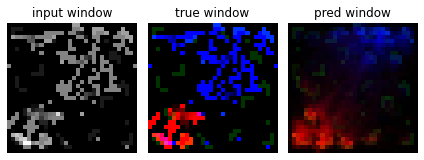

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


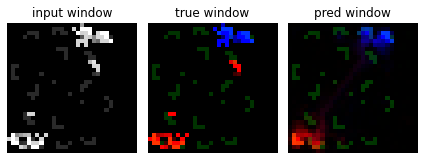

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


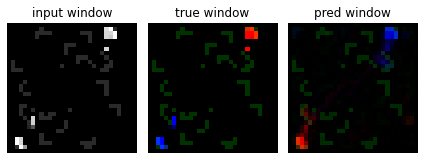

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


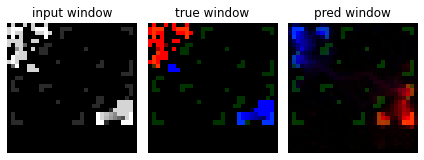

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


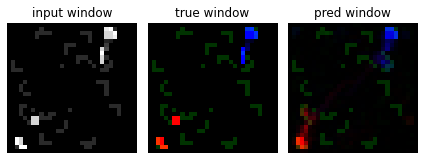


Epoch 11 / 100
----------
	Batch 19/196:  running loss=0.014
	Batch 39/196:  running loss=0.014
	Batch 59/196:  running loss=0.014
	Batch 79/196:  running loss=0.014
	Batch 99/196:  running loss=0.014
	Batch 119/196:  running loss=0.014
	Batch 139/196:  running loss=0.014
	Batch 159/196:  running loss=0.014
	Batch 179/196:  running loss=0.014
Total train	Loss: 0.0139
Total val	Loss: 0.0193

Epoch 12 / 100
----------
	Batch 19/196:  running loss=0.014
	Batch 39/196:  running loss=0.014
	Batch 59/196:  running loss=0.014
	Batch 79/196:  running loss=0.014
	Batch 99/196:  running loss=0.014
	Batch 119/196:  running loss=0.014
	Batch 139/196:  running loss=0.014
	Batch 159/196:  running loss=0.014
	Batch 179/196:  running loss=0.014
Total train	Loss: 0.0138
Total val	Loss: 0.0162

Epoch 13 / 100
----------
	Batch 19/196:  running loss=0.014
	Batch 39/196:  running loss=0.014
	Batch 59/196:  running loss=0.014
	Batch 79/196:  running loss=0.014
	Batch 99/196:  running loss=0.014
	Batch 119

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0174


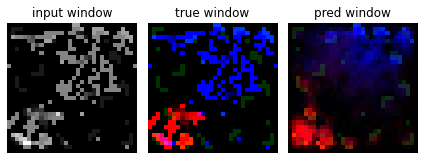

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


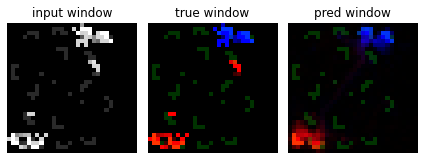

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


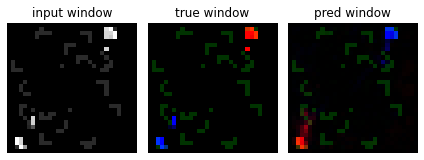

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


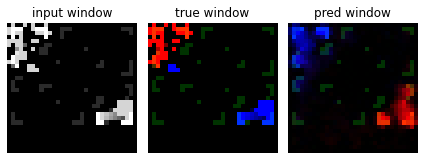

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


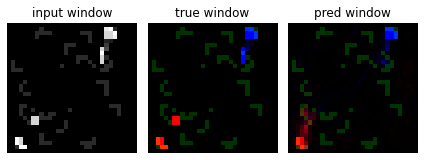


Epoch 21 / 100
----------
	Batch 19/196:  running loss=0.013
	Batch 39/196:  running loss=0.012
	Batch 59/196:  running loss=0.012
	Batch 79/196:  running loss=0.012
	Batch 99/196:  running loss=0.012
	Batch 119/196:  running loss=0.012
	Batch 139/196:  running loss=0.012
	Batch 159/196:  running loss=0.012
	Batch 179/196:  running loss=0.012
Total train	Loss: 0.0150
Total val	Loss: 258471.1306

Epoch 22 / 100
----------
	Batch 19/196:  running loss=0.560
	Batch 39/196:  running loss=0.297
	Batch 59/196:  running loss=0.207
	Batch 79/196:  running loss=0.161
	Batch 99/196:  running loss=0.133
	Batch 119/196:  running loss=0.114
	Batch 139/196:  running loss=0.101
	Batch 159/196:  running loss=0.091
	Batch 179/196:  running loss=0.083
Total train	Loss: 0.0780
Total val	Loss: 0.0213

Epoch 23 / 100
----------
	Batch 19/196:  running loss=0.020
	Batch 39/196:  running loss=0.019
	Batch 59/196:  running loss=0.019
	Batch 79/196:  running loss=0.019
	Batch 99/196:  running loss=0.019
	Batc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0146


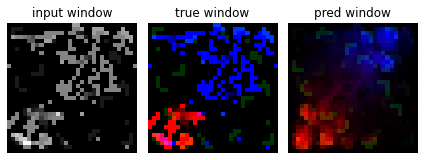

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


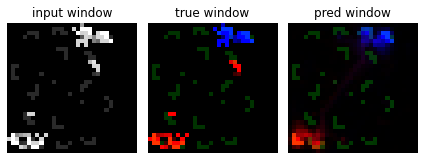

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


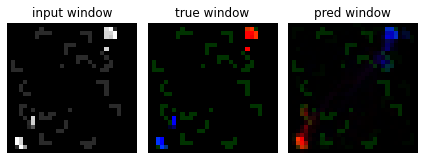

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


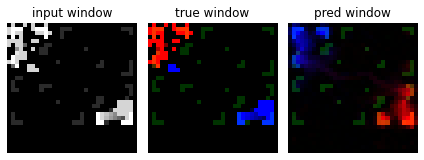

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


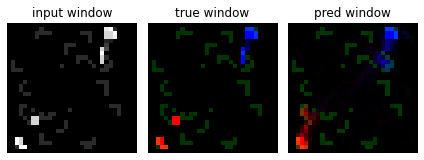


Epoch 31 / 100
----------
	Batch 19/196:  running loss=0.014
	Batch 39/196:  running loss=0.014
	Batch 59/196:  running loss=0.014
	Batch 79/196:  running loss=0.014
	Batch 99/196:  running loss=0.014
	Batch 119/196:  running loss=0.014
	Batch 139/196:  running loss=0.014
	Batch 159/196:  running loss=0.014
	Batch 179/196:  running loss=0.014
Total train	Loss: 0.0142
Total val	Loss: 0.0142
New best validation! Model saved.

Epoch 32 / 100
----------
	Batch 19/196:  running loss=0.014
	Batch 39/196:  running loss=0.014
	Batch 59/196:  running loss=0.014
	Batch 79/196:  running loss=0.014
	Batch 99/196:  running loss=0.014
	Batch 119/196:  running loss=0.014
	Batch 139/196:  running loss=0.014
	Batch 159/196:  running loss=0.014
	Batch 179/196:  running loss=0.014
Total train	Loss: 0.0140
Total val	Loss: 0.0141
New best validation! Model saved.

Epoch 33 / 100
----------
	Batch 19/196:  running loss=0.014
	Batch 39/196:  running loss=0.014
	Batch 59/196:  running loss=0.014
	Batch 79/19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0131


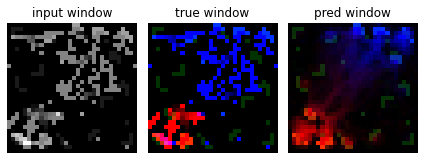

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


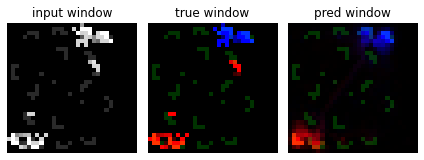

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


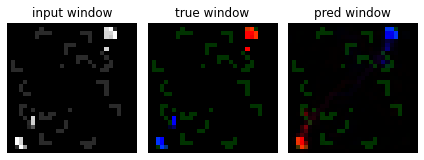

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


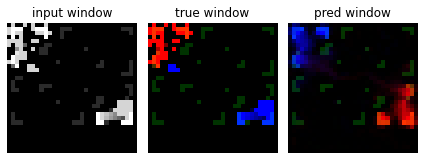

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


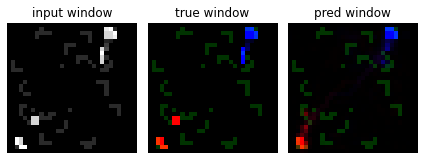

New best validation! Model saved.

Epoch 41 / 100
----------
	Batch 19/196:  running loss=0.013
	Batch 39/196:  running loss=0.013
	Batch 59/196:  running loss=0.013
	Batch 79/196:  running loss=0.013
	Batch 99/196:  running loss=0.013
	Batch 119/196:  running loss=0.013
	Batch 139/196:  running loss=0.013
	Batch 159/196:  running loss=0.013
	Batch 179/196:  running loss=0.013
Total train	Loss: 0.0129
Total val	Loss: 0.0130
New best validation! Model saved.

Epoch 42 / 100
----------
	Batch 19/196:  running loss=0.013
	Batch 39/196:  running loss=0.013
	Batch 59/196:  running loss=0.013
	Batch 79/196:  running loss=0.013
	Batch 99/196:  running loss=0.013
	Batch 119/196:  running loss=0.013
	Batch 139/196:  running loss=0.013
	Batch 159/196:  running loss=0.013
	Batch 179/196:  running loss=0.013
Total train	Loss: 0.0128
Total val	Loss: 0.0129
New best validation! Model saved.

Epoch 43 / 100
----------
	Batch 19/196:  running loss=0.013
	Batch 39/196:  running loss=0.013
	Batch 59/196

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0122


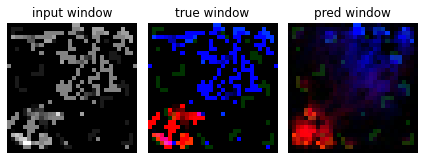

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


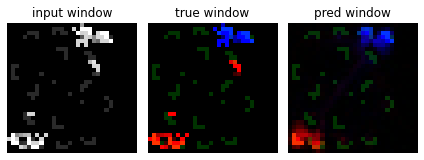

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


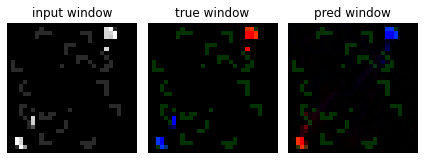

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


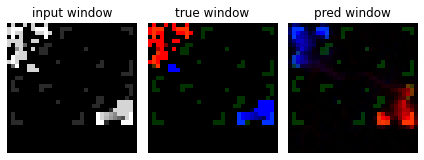

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


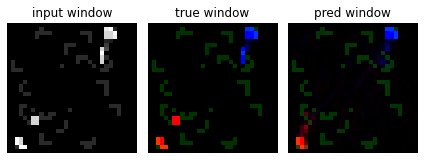

New best validation! Model saved.

Epoch 51 / 100
----------
	Batch 19/196:  running loss=0.012
	Batch 39/196:  running loss=0.012
	Batch 59/196:  running loss=0.012
	Batch 79/196:  running loss=0.012
	Batch 99/196:  running loss=0.012
	Batch 119/196:  running loss=0.012
	Batch 139/196:  running loss=0.012
	Batch 159/196:  running loss=0.012
	Batch 179/196:  running loss=0.012
Total train	Loss: 0.0121
Total val	Loss: 0.0122
New best validation! Model saved.

Epoch 52 / 100
----------
	Batch 19/196:  running loss=0.012
	Batch 39/196:  running loss=0.012
	Batch 59/196:  running loss=0.012
	Batch 79/196:  running loss=0.012
	Batch 99/196:  running loss=0.012
	Batch 119/196:  running loss=0.012
	Batch 139/196:  running loss=0.012
	Batch 159/196:  running loss=0.012
	Batch 179/196:  running loss=0.012
Total train	Loss: 0.0121
Total val	Loss: 0.0122
New best validation! Model saved.

Epoch 53 / 100
----------
	Batch 19/196:  running loss=0.012
	Batch 39/196:  running loss=0.012
	Batch 59/196

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0116


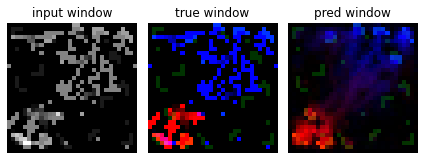

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


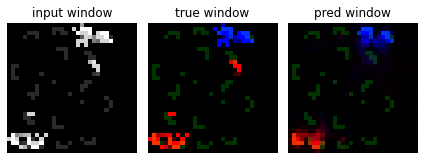

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


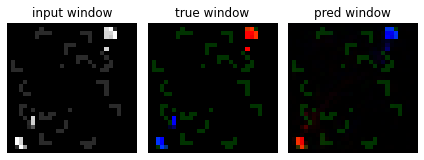

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


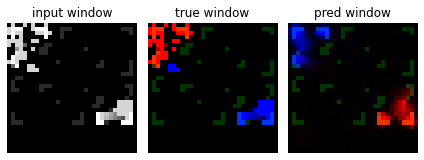

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


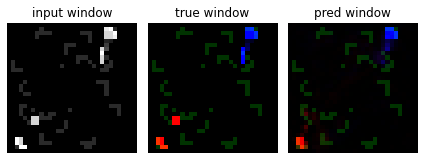

New best validation! Model saved.

Epoch 61 / 100
----------
	Batch 19/196:  running loss=0.012
	Batch 39/196:  running loss=0.012
	Batch 59/196:  running loss=0.012
	Batch 79/196:  running loss=0.011
	Batch 99/196:  running loss=0.011
	Batch 119/196:  running loss=0.011
	Batch 139/196:  running loss=0.011
	Batch 159/196:  running loss=0.011
	Batch 179/196:  running loss=0.011
Total train	Loss: 0.0114
Total val	Loss: 0.0116

Epoch 62 / 100
----------
	Batch 19/196:  running loss=0.011
	Batch 39/196:  running loss=0.011
	Batch 59/196:  running loss=0.011
	Batch 79/196:  running loss=0.011
	Batch 99/196:  running loss=0.011
	Batch 119/196:  running loss=0.011
	Batch 139/196:  running loss=0.011
	Batch 159/196:  running loss=0.011
	Batch 179/196:  running loss=0.011
Total train	Loss: 0.0114
Total val	Loss: 0.0115
New best validation! Model saved.

Epoch 63 / 100
----------
	Batch 19/196:  running loss=0.011
	Batch 39/196:  running loss=0.011
	Batch 59/196:  running loss=0.011
	Batch 79/19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0111


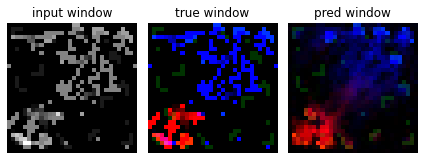

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


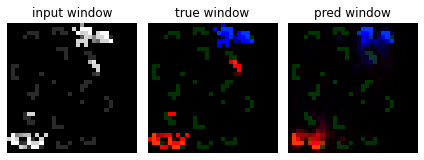

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


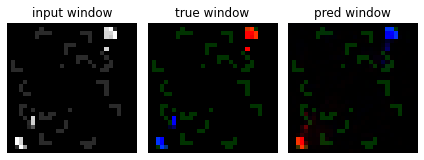

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


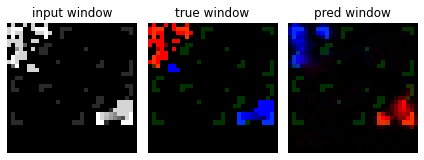

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


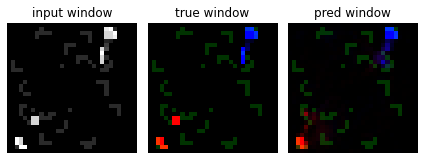

New best validation! Model saved.

Epoch 71 / 100
----------
	Batch 19/196:  running loss=0.011
	Batch 39/196:  running loss=0.011
	Batch 59/196:  running loss=0.011
	Batch 79/196:  running loss=0.011
	Batch 99/196:  running loss=0.011
	Batch 119/196:  running loss=0.011
	Batch 139/196:  running loss=0.011
	Batch 159/196:  running loss=0.011
	Batch 179/196:  running loss=0.011
Total train	Loss: 0.0109
Total val	Loss: 0.0110
New best validation! Model saved.

Epoch 72 / 100
----------
	Batch 19/196:  running loss=0.011
	Batch 39/196:  running loss=0.011
	Batch 59/196:  running loss=0.011
	Batch 79/196:  running loss=0.011
	Batch 99/196:  running loss=0.011
	Batch 119/196:  running loss=0.011
	Batch 139/196:  running loss=0.011
	Batch 159/196:  running loss=0.011
	Batch 179/196:  running loss=0.011
Total train	Loss: 0.0108
Total val	Loss: 0.0110
New best validation! Model saved.

Epoch 73 / 100
----------
	Batch 19/196:  running loss=0.011
	Batch 39/196:  running loss=0.011
	Batch 59/196

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 0.0108


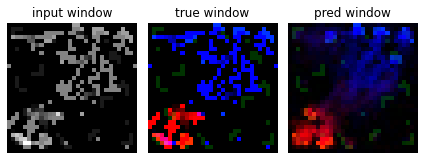

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


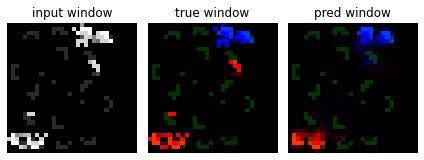

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


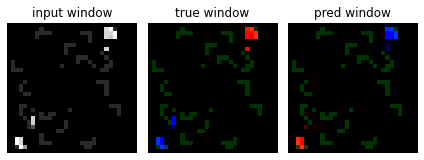

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


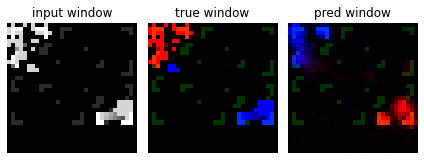

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


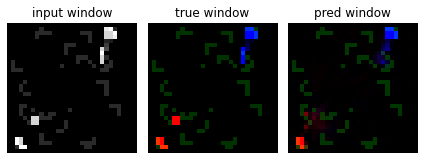


Epoch 81 / 100
----------
	Batch 19/196:  running loss=0.010
	Batch 39/196:  running loss=0.010
	Batch 59/196:  running loss=0.010
	Batch 79/196:  running loss=0.010
	Batch 99/196:  running loss=0.010
	Batch 119/196:  running loss=0.010
	Batch 139/196:  running loss=0.010
	Batch 159/196:  running loss=0.010
	Batch 179/196:  running loss=0.010
Total train	Loss: 0.0103
Total val	Loss: 0.1404

Epoch 82 / 100
----------
	Batch 19/196:  running loss=0.010
	Batch 39/196:  running loss=0.010
	Batch 59/196:  running loss=0.010
	Batch 79/196:  running loss=0.010
	Batch 99/196:  running loss=0.010
	Batch 119/196:  running loss=0.010
	Batch 139/196:  running loss=0.010
	Batch 159/196:  running loss=0.010
	Batch 179/196:  running loss=0.010
Total train	Loss: 0.0102
Total val	Loss: 0.0148

Epoch 83 / 100
----------
	Batch 19/196:  running loss=0.010
	Batch 39/196:  running loss=0.010
	Batch 59/196:  running loss=0.010
	Batch 79/196:  running loss=0.010
	Batch 99/196:  running loss=0.010
	Batch 119

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 26.8938


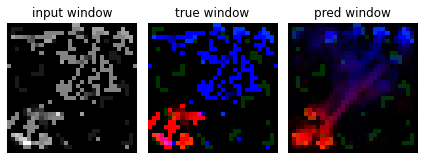

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


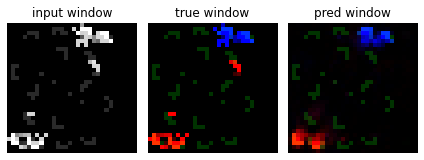

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


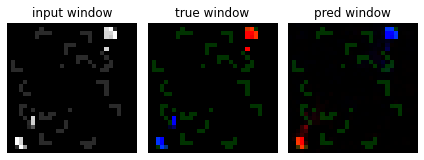

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


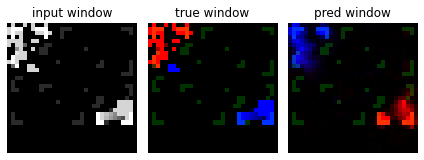

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


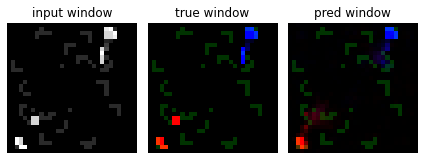


Epoch 91 / 100
----------
	Batch 19/196:  running loss=0.011
	Batch 39/196:  running loss=0.010
	Batch 59/196:  running loss=0.010
	Batch 79/196:  running loss=0.010
	Batch 99/196:  running loss=0.010
	Batch 119/196:  running loss=0.010
	Batch 139/196:  running loss=0.010
	Batch 159/196:  running loss=0.010
	Batch 179/196:  running loss=0.010
Total train	Loss: 0.0105
Total val	Loss: 280.5226

Epoch 92 / 100
----------
	Batch 19/196:  running loss=0.011
	Batch 39/196:  running loss=0.011
	Batch 59/196:  running loss=0.012
	Batch 79/196:  running loss=0.013
	Batch 99/196:  running loss=0.013
	Batch 119/196:  running loss=0.013
	Batch 139/196:  running loss=0.013
	Batch 159/196:  running loss=0.013
	Batch 179/196:  running loss=0.013
Total train	Loss: 0.0130
Total val	Loss: 29.5307

Epoch 93 / 100
----------
	Batch 19/196:  running loss=0.014
	Batch 39/196:  running loss=0.014
	Batch 59/196:  running loss=0.014
	Batch 79/196:  running loss=0.013
	Batch 99/196:  running loss=0.013
	Batch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total val	Loss: 320.9056


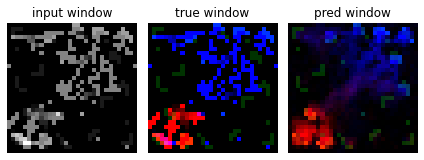

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


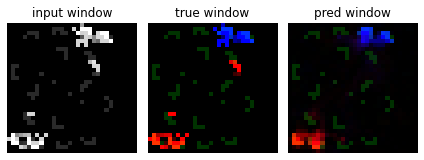

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


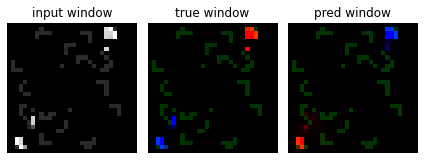

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


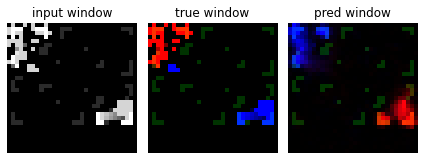

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


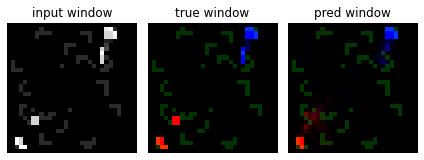


Training complete in 29m 47s
Best model saved to models/unit-colorization/model.pt
	Best model val loss: 0.0107


In [11]:
# training vae on frame prediction
model_dir = model_root_dir / 'unit-colorization'
n_epochs = 100

model, train_hist, val_hist = train_model(model, dataloaders, criterion,
                                          optimizer, model_dir, device, n_epochs=n_epochs)

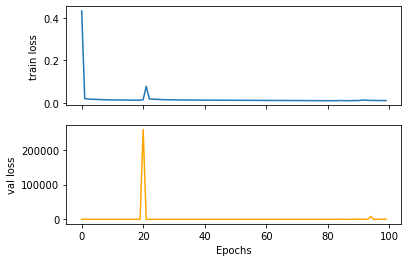

In [12]:
# Displaying training results
fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(train_hist, label='train')
axes[0].set_ylabel('train loss')
axes[1].plot(val_hist, label='val', color='orange')
axes[1].set_ylabel('val loss')
axes[1].set_xlabel('Epochs')
plt.savefig(model_dir / 'train_val_plots.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


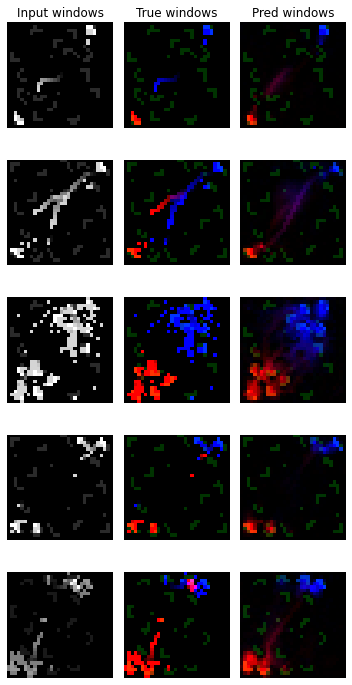

In [32]:
def plot_frames(frames, show=True, axes=None, line_idx=None):
    """frames must be len=3 (input, true, pred)"""
    if axes is None:
        fig, axes = plt.subplots(1, 3)
    else:
        assert axes.ndim == 1
    if line_idx == 0:    
        imshow(frames[1], ax=axes[1], title='True windows')
        imshow(frames[2], ax=axes[2], title='Pred windows')
        imshow(frames[0], ax=axes[0], title='Input windows')
    else:
        imshow(frames[1], ax=axes[1])
        imshow(frames[2], ax=axes[2])
        imshow(frames[0], ax=axes[0])
    for ax in axes:
        ax.axis('off')
    
    if show:
        plt.tight_layout()
        plt.show()
    return axes

def test_and_plot_model(model, dataloader, n_test_samples=10, axes=None, rng=None):
    if rng is None:
        rng = np.random.RandomState(42)
    for (inputs, targets) in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            # get model predictions and calculate loss
            predictions = model(inputs)
        break
        
    for sample_idx in range(n_test_samples):
        idx = rng.choice(predictions.shape[0])
        if axes is None:
            plot_frames([inputs[idx].cpu(), targets[idx].cpu(), predictions[idx].cpu()])
        else:
            plot_frames([inputs[idx].cpu(), targets[idx].cpu(), predictions[idx].cpu()],
                        axes=axes[sample_idx], show=False, line_idx=sample_idx)
    return inputs, predictions, targets

def plot_batch(model, batch):
    inputs, targets = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        # get model predictions and calculate loss
        predictions = model(inputs)
    for i, t, p in zip(inputs, targets, predictions):
        plot_frames([i.cpu(), t.cpu(), p.cpu()])

fig, axes = plt.subplots(5, 3, figsize=(5,10))

rng = np.random.RandomState(np.random.randint(1000))
_ = test_and_plot_model(model, dataloaders['val'], n_test_samples=5, rng=rng, axes=axes)
plt.tight_layout()
plt.savefig('image-colorization.pdf')
plt.show()